# Introduction

This project aims to 

In the ever-evolving field of machine learning, decision trees have been a cornerstone for both theoretical research and practical applications due to their simplicity and interpretability. This project explores the implementation of a [Hoeffding Option Tree (HOT)](https://link.springer.com/chapter/10.1007/978-3-540-76928-6_11) Classifier, which introduces the concept on Option Node to the classical Hoeffding Tree. 

The primary objective of this project is to highlight the advantages of HOT as an online learning classifier and to provide a comprehensive comparison with the (offline) Decision Tree and the Hoeffding Tree. This comparison is crucial for understanding the trade-offs between offline and online learning paradigms and for selecting the appropriate model based on the specific requirements of the application at hand. For simplicity, the model(s) have been trained on the well known _iris_ dataset, where, with its simplicity is a good starting point to illustrate and test classification task. 

This project is integrated with the [_River_ library](https://riverml.xyz/latest/), a Python framework for online machine learning, which facilitates the implementation and evaluation of these tree-based models. Through this integration, we demonstrate how these algorithms can be applied in practical settings, particularly focusing on their performance in terms of accuracy, computational efficiency, and adaptability to data streams.

In [56]:
import matplotlib.pyplot as plt

models = ["Offline Decision Tree", "Hoeffding Tree", "Hoeffding Option Tree"]
results = {}

# Results

In this section is presented a comparative analysis between the performances of Hoeffding Option Tree classifier with the classical _Decision Tree_ classifier from scikit-learn library and the _Hoffding Tree_ classifier from the River library. This comparison is based on several evaluation metrics, including accuracy, precision, recall and computational efficiency.

The dataset used during experiments are low-dimension dataset for classification task

## Offline Decision Tree - Sklearn

In [82]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


iris = datasets.load_iris()
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, test_size=0.3, stratify=iris.target, random_state=42
)
offline_dt = DecisionTreeClassifier(random_state=0)
offline_dt.fit(X_train, y_train)
y_pred = offline_dt.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")
cm = confusion_matrix(y_test, y_pred, labels=offline_dt.classes_)
print(f'Model accuracy: {accuracy:.4f}')

results["Offline Decision Tree"] = dict(model=offline_dt,
                                        accuracy=accuracy,
                                        f1_score=f1,
                                        cm=cm)

Model accuracy: 0.9778


## Online Hoeffding Tree - River



In [86]:
from river.stream import iter_sklearn_dataset
from river.tree import HoeffdingTreeClassifier
from river.metrics import Accuracy, WeightedF1

hoeffding_tree = HoeffdingTreeClassifier(tau=1.5, grace_period=3)
accuracy = Accuracy()
f1 = WeightedF1()
accuracy_over_time = []

for x, y in iter_sklearn_dataset(iris, shuffle=True, seed=42):
    y_pred = hoeffding_tree.predict_one(x)
    if y_pred is not None:
        accuracy.update(y, y_pred)
        f1.update(y, y_pred)
        accuracy_over_time.append(accuracy.get())
    hoeffding_tree.learn_one(x, y)

cm = accuracy.cm
print(f'Model accuracy: {accuracy.get():.4f}')

results["Hoeffding Tree"] = dict(accuracy=accuracy.get(),
                                 f1_score=f1.get(),
                                 cm=cm,
                                 accuracy_over_time=accuracy_over_time)

Split on petal width (cm)	 Parent: NoneType
Split on petal width (cm)	 Parent: petal width (cm)
Split on petal width (cm)	 Parent: petal width (cm)
Split on petal width (cm)	 Parent: petal width (cm)
Split on petal width (cm)	 Parent: petal width (cm)
Split on petal width (cm)	 Parent: petal width (cm)
Split on sepal width (cm)	 Parent: petal width (cm)
Model accuracy: 0.8859


## Hoeffding Option Tree

$\delta = 0.955$

In [87]:
from hoeffding_option_tree import HoeffdingOptionTreeClassifier
from river.metrics import Accuracy, WeightedF1

hot = HoeffdingOptionTreeClassifier(tau=1.5, grace_period=3,
                                               delta_prime=0.955,
                                               max_options=3)
accuracy = Accuracy()
f1 = WeightedF1()
accuracy_over_time = []

for x, y in iter_sklearn_dataset(iris, shuffle=True, seed=42):
    y_pred = hoeffding_tree.predict_one(x)
    if y_pred is not None:
        accuracy.update(y, y_pred)
        f1.update(y, y_pred)
        accuracy_over_time.append(accuracy.get())
    hot.learn_one(x, y)

cm = accuracy.cm
print(f"Accuracy: {accuracy.get():.4f}")

results["Hoeffding Option Tree"] = dict(accuracy=accuracy.get(), 
                                        f1_score=f1.get(), 
                                        cm=cm, 
                                        accuracy_over_time=accuracy_over_time)

Accuracy: 0.9333


## Comparison

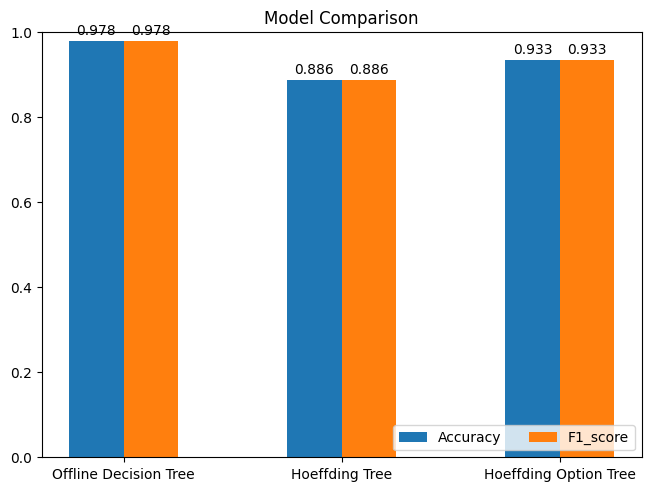

In [117]:
import matplotlib.pyplot as plt
import numpy as np

x_labels = results.keys()
data = {
    "Accuracy": [round(results[model]["accuracy"], 3) for model in results],
    "F1_score": [round(results[model]["f1_score"], 3) for model in results]
}

x = np.arange(len(x_labels))
width = 0.25  # the width of the bars
multiplier = 0.5

fig, ax = plt.subplots(layout='constrained')

for model_name, metrics in data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, metrics, width, label=model_name)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_title('Model Comparison')
ax.set_xticks(x + width, x_labels)
ax.set_ylim(0, 1)

plt.legend(loc='lower right', ncols=2)
plt.show()

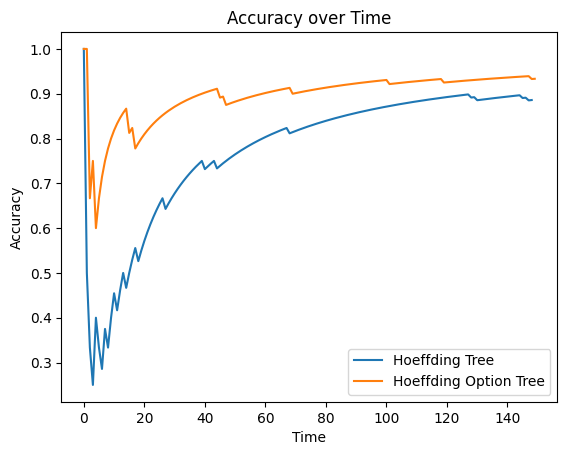

In [128]:
for model in results:
    if "accuracy_over_time" not in results[model]:
        continue

    data = results[model]["accuracy_over_time"]
    plt.plot(data, label=model)
    plt.legend() 
    plt.title("Accuracy over Time")
    plt.xlabel("Time")
    plt.ylabel("Accuracy")

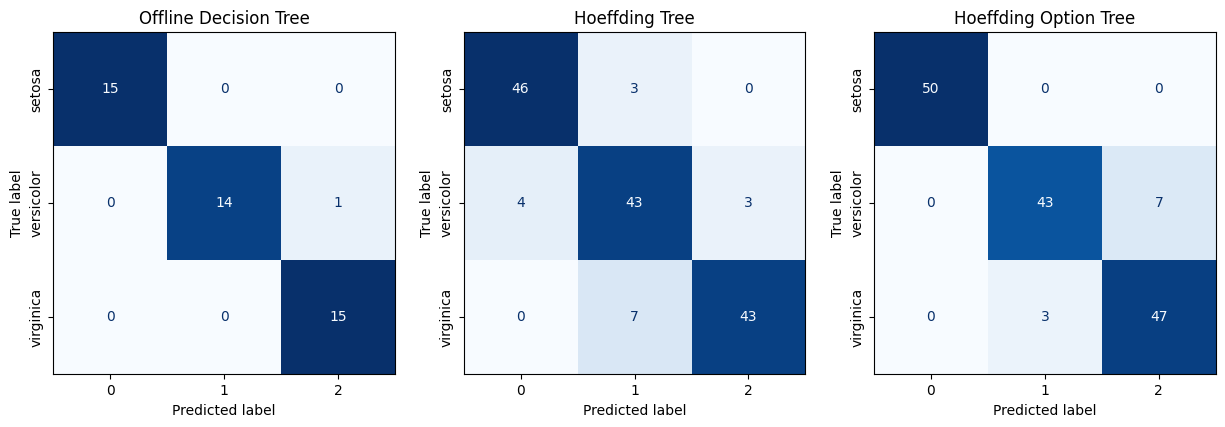

In [181]:
import river
from sklearn.metrics import ConfusionMatrixDisplay
label_mapping = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}

n = len(results.keys())
fig, axs = plt.subplots(1, n, figsize=(15, 15))

for i, model in enumerate(results):
    cm = results[model]["cm"]
    # convert river.metrics.ConfusionMatrix to numpy.ndarray in order to be plotted by Sklearn.metrics.ConfusionMatrixDisplay
    if isinstance(cm, river.metrics.ConfusionMatrix):
        labels = list(cm.classes)
        cm = np.array([[cm[x][y] for y in labels] for x in labels])
    
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=axs[i], cmap=plt.cm.Blues, colorbar=False)
    axs[i].set_yticklabels(list(map(label_mapping.get, label_mapping.keys())), rotation=90, va="center")
    axs[i].set_title(model)